In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize the data
y_train_cat = to_categorical(y_train)  # One-hot encoding for the labels
y_test_cat = to_categorical(y_test)

# simple neural network model
def create_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model()

# Train the model
history = model.fit(x_train, y_train_cat, epochs=10, validation_split=0.2, verbose=2)

# Evaluate the model on the test dataset
baseline_accuracy = model.evaluate(x_test, y_test_cat, verbose=0)[1]
print(f"Baseline Accuracy: {baseline_accuracy*100:.2f}%")


2024-03-17 18:48:27.429962: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 18:48:27.430149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 18:48:27.640065: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1500/1500 - 7s - 5ms/step - accuracy: 0.9164 - loss: 0.2940 - val_accuracy: 0.9542 - val_loss: 0.1603
Epoch 2/10
1500/1500 - 9s - 6ms/step - accuracy: 0.9614 - loss: 0.1327 - val_accuracy: 0.9617 - val_loss: 0.1228
Epoch 3/10
1500/1500 - 5s - 4ms/step - accuracy: 0.9727 - loss: 0.0905 - val_accuracy: 0.9682 - val_loss: 0.1049
Epoch 4/10
1500/1500 - 5s - 3ms/step - accuracy: 0.9806 - loss: 0.0663 - val_accuracy: 0.9743 - val_loss: 0.0878
Epoch 5/10
1500/1500 - 5s - 4ms/step - accuracy: 0.9847 - loss: 0.0507 - val_accuracy: 0.9726 - val_loss: 0.0911
Epoch 6/10
1500/1500 - 10s - 7ms/step - accuracy: 0.9885 - loss: 0.0391 - val_accuracy: 0.9741 - val_loss: 0.0853
Epoch 7/10
1500/1500 - 10s - 7ms/step - accuracy: 0.9905 - loss: 0.0312 - val_accuracy: 0.9757 - val_loss: 0.0881
Epoch 8/10
1500/1500 - 10s - 7ms/step - accuracy: 0.9929 - loss: 0.0242 - val_accuracy: 0.9741 - val_loss: 0.0946
Epoch 9/10
1500/1500 - 5s - 3ms/step - accuracy: 0.9938 - loss: 0.0202 - val_accuracy: 0.9770

In [3]:
def strategically_flip_labels(y, percentage=0.9):
    """
    Flips labels within the training set to a strategically chosen class to maximize confusion.
    `percentage` controls what fraction of the dataset to manipulate.
    """
    np.random.seed(42)  # reproducibility
    indices = np.random.choice(np.arange(len(y)), replace=False,
                               size=int(len(y) * percentage))
    # Mapping designed to maximize confusion
    confusion_map = {0: 8, 1: 7, 2: 8, 3: 8, 4: 9, 5: 8, 6: 8, 7: 1, 8: 0, 9: 4}
    
    y_flipped = y.copy()
    for idx in indices:
        original_label = y[idx]
        y_flipped[idx] = confusion_map[original_label]
    
    return y_flipped

# Percentage of labels to manipulate
percentages = [0.1, 0.2, 0.5, 0.7, 0.8, 0.85, 0.9, 0.98]
accuracies = []

for percentage in percentages:
    # Flip labels and convert to categorical
    y_train_flipped = strategically_flip_labels(y_train, percentage)
    y_train_flipped_cat = to_categorical(y_train_flipped)


In [4]:
for percentage in percentages:
    # Flip labels and convert to categorical
    y_train_flipped = strategically_flip_labels(y_train, percentage)
    y_train_flipped_cat = to_categorical(y_train_flipped)

    # Create a new labels of the model 
    model_with_flipped_labels = create_model()

    # Re-train the model with strategically flipped labels
    history_flipped = model_with_flipped_labels.fit(x_train, y_train_flipped_cat, epochs=10, validation_split=0.2, verbose=2)

    # Evaluate the model on the test dataset
    accuracy_with_flipped = model_with_flipped_labels.evaluate(x_test, y_test_cat, verbose=0)[1]
    accuracies.append(accuracy_with_flipped)
    print(f"Accuracy with {percentage*100}% Manipulated Labels: {accuracy_with_flipped*100:.2f}%")


Epoch 1/10
1500/1500 - 7s - 4ms/step - accuracy: 0.8123 - loss: 0.6376 - val_accuracy: 0.8616 - val_loss: 0.4992
Epoch 2/10
1500/1500 - 10s - 7ms/step - accuracy: 0.8560 - loss: 0.4849 - val_accuracy: 0.8698 - val_loss: 0.4629
Epoch 3/10
1500/1500 - 10s - 7ms/step - accuracy: 0.8671 - loss: 0.4396 - val_accuracy: 0.8658 - val_loss: 0.4497
Epoch 4/10
1500/1500 - 10s - 7ms/step - accuracy: 0.8744 - loss: 0.4120 - val_accuracy: 0.8734 - val_loss: 0.4367
Epoch 5/10
1500/1500 - 10s - 7ms/step - accuracy: 0.8789 - loss: 0.3914 - val_accuracy: 0.8701 - val_loss: 0.4404
Epoch 6/10
1500/1500 - 11s - 7ms/step - accuracy: 0.8824 - loss: 0.3747 - val_accuracy: 0.8725 - val_loss: 0.4506
Epoch 7/10
1500/1500 - 10s - 6ms/step - accuracy: 0.8861 - loss: 0.3585 - val_accuracy: 0.8711 - val_loss: 0.4377
Epoch 8/10
1500/1500 - 5s - 4ms/step - accuracy: 0.8879 - loss: 0.3452 - val_accuracy: 0.8730 - val_loss: 0.4415
Epoch 9/10
1500/1500 - 5s - 4ms/step - accuracy: 0.8913 - loss: 0.3326 - val_accuracy: 0.8

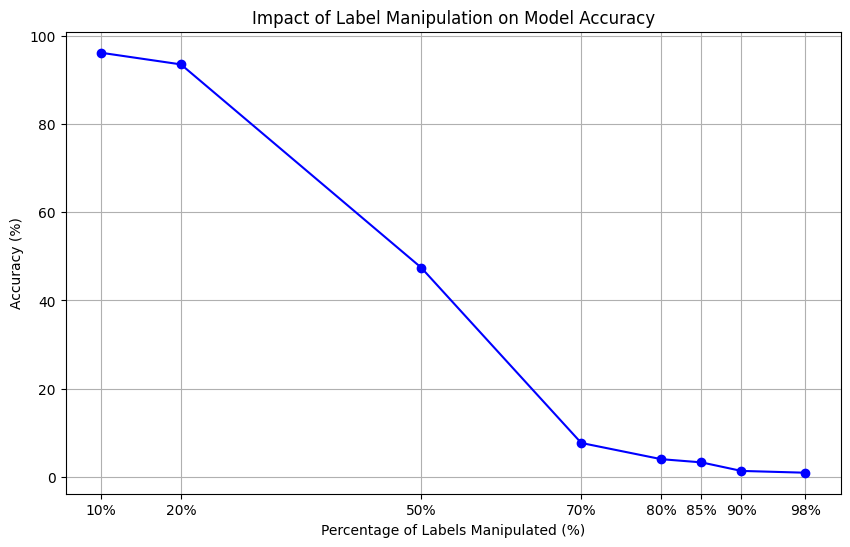

In [5]:
# Plotting the impact of label manipulation
plt.figure(figsize=(10, 6))
plt.plot(percentages, [a*100 for a in accuracies], marker='o', linestyle='-', color='blue')
plt.title('Impact of Label Manipulation on Model Accuracy')
plt.xlabel('Percentage of Labels Manipulated (%)')
plt.ylabel('Accuracy (%)')
plt.xticks(percentages, [f"{p*100:.0f}%" for p in percentages])
plt.grid(True)
plt.show()